### Nicht augmentierten Daten

In [1]:
file_id="1uKc-AC5sRTU0BU1qGlV8MPOIv2xZills"
!gdown https://drive.google.com/uc?id={file_id}

Downloading...
From (original): https://drive.google.com/uc?id=1uKc-AC5sRTU0BU1qGlV8MPOIv2xZills
From (redirected): https://drive.google.com/uc?id=1uKc-AC5sRTU0BU1qGlV8MPOIv2xZills&confirm=t&uuid=5f4c39f8-5ab1-4ffd-9ef7-a761880ccec7
To: /content/Plant_leaf_diseases_dataset_without_augmentation.zip
100% 868M/868M [00:14<00:00, 58.9MB/s]


In [2]:
!unzip -q /content/Plant_leaf_diseases_dataset_without_augmentation.zip

## Erste Schritte

In [3]:
!pip install opencv-python

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Plotting 5 samples of Apple___healthy:


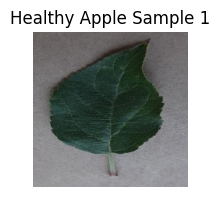

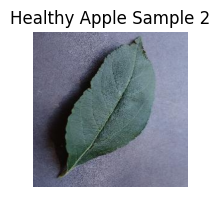

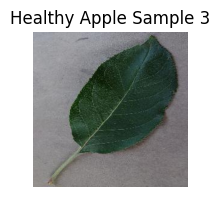

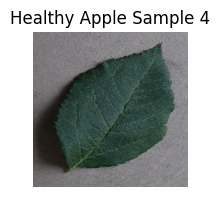

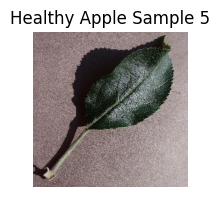

In [5]:
print("Plotting 5 samples of Apple___healthy:")
healthy_path = "/content/Plant_leave_diseases_dataset_without_augmentation/Apple___healthy"
healthy_files_list = os.listdir(healthy_path)

num_samples = 5 # Sample
selected_healthy_files = healthy_files_list[:num_samples]

next_healthy_plant = [os.path.join(healthy_path, fname) for fname in selected_healthy_files]

for i, img_path in enumerate(next_healthy_plant):
    img = mpimg.imread(img_path)
    plt.figure(figsize=(2, 3))
    plt.imshow(img)
    plt.title(f"Healthy Apple Sample {i+1}")
    plt.axis('Off')
    plt.show()


### Train-Test-Datenaufteilung

In [11]:
import random
import shutil

# Verzeichnisse
data_dir = "/content/Plant_leave_diseases_dataset_without_augmentation"
train_dir = "/content/train_dataset"
test_dir = "/content/test_dataset"

# Erstelle Zielordner für Test- und Trainingsdaten
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# Gehe durch alle Klassen
for root, dirs, files in os.walk(data_dir):
    for class_name in dirs:
        # Überprüfe, ob der Ordner tatsächlich Bilder enthält
        class_path = os.path.join(root, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg'))]

        if image_files:
            sample_size = int(0.2 * len(image_files))  # 20% für Testdaten
            sampled_files = random.sample(image_files, sample_size)

            # Kopiere Testdaten
            for file in sampled_files:
                src_path = os.path.join(class_path, file)
                dest_path = os.path.join(test_dir, class_name, file)
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.copy(src_path, dest_path)

            # Kopiere Trainingsdaten (der Rest der Bilder)
            remaining_files = set(image_files) - set(sampled_files)
            for file in remaining_files:
                src_path = os.path.join(class_path, file)
                dest_path = os.path.join(train_dir, class_name, file)
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.copy(src_path, dest_path)

print("Train-Test-Datenaufteilung abgeschlossen.")

Train-Test-Datenaufteilung abgeschlossen.


### Bildaugmentation für Trainingsdatensatz

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentierung für den Trainingsdatensatz
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Bildskalierung
    rotation_range=40,          # Rotation
    width_shift_range=0.2,      # Verschiebung in der Breite
    height_shift_range=0.2,     # Verschiebung in der Höhe
    shear_range=0.2,            # Scherung
    zoom_range=0.2,             # Zoom
    horizontal_flip=True,       # Horizontal spiegeln
    fill_mode='nearest'         # Füllen der leeren Stellen
)

# Ohne Augmentierungen für Testdaten
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Trainingsdaten mit Augmentierungen
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Eingabebildgröße
    batch_size=32,
    class_mode='categorical'  # Mehrklassenklassifikation
)

# Testdaten ohne Augmentierungen
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 55448 images belonging to 39 classes.
Found 11077 images belonging to 39 classes.


### VGG16-Modell laden

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# VGG16 ohne die obersten Schichten (Fully-Connetcted-Schicht)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Einfrieren der Basis-Model-Schichten, um sie nicht während des Trainings zu ändern
for layer in base_model.layers:
    layer.trainable = False

# Hinzufügen von eigenen Klassifikationsschichten
model = Sequential([
    base_model,  # Vortrainiertes VGG16-Modell
    Flatten(),  # Flache Schicht
    Dense(512, activation='relu'),  # Dense-Schicht
    Dropout(0.5),  # Dropout zur Vermeidung von Überanpassung
    Dense(train_generator.num_classes, activation='softmax')  # Softmax für Mehrklassenklassifikation
])

# Kompilieren des Modells
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam-Optimierer
    loss='categorical_crossentropy',  # Verlustfunktion für Mehrklassenklassifikation
    metrics=['accuracy']  # Metrik zur Bewertung der Genauigkeit
)

# Modell trainieren
history = model.fit(
    train_generator,  # Trainingsdaten mit Augmentierung
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Schritte pro Epoche
    epochs=10,  # Anzahl der Epochen
    validation_data=test_generator,  # Testdaten ohne Augmentierung
    validation_steps=test_generator.samples // test_generator.batch_size  # Schritte für die Validierung
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 819s 465ms/step - accuracy: 0.3743 - loss: 2.3715 - val_accuracy: 0.7752 - val_loss: 0.7339
Epoch 2/10
   1/1732 ━━━━━━━━━━━━━━━━━━━━ 4:53 170ms/step - accuracy: 0.4688 - loss: 1.7079

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1732/1732 ━━━━━━━━━━━━━━━━━━━━ 62s 36ms/step - accuracy: 0.4688 - loss: 1.7079 - val_accuracy: 0.7738 - val_loss: 0.7309
Epoch 3/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 863s 474ms/step - accuracy: 0.5388 - loss: 1.4622 - val_accuracy: 0.7957 - val_loss: 0.6560
Epoch 4/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.4375 - loss: 1.5849 - val_accuracy: 0.7975 - val_loss: 0.6547
Epoch 5/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 833s 458ms/step - accuracy: 0.5703 - loss: 1.3572 - val_accuracy: 0.7997 - val_loss: 0.5696
Epoch 6/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 62s 36ms/step - accuracy: 0.5938 - loss: 1.0906 - val_accuracy: 0.8013 - val_loss: 0.5612
Epoch 7/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 802s 463ms/step - accuracy: 0.5833 - loss: 1.2932 - val_accuracy: 0.8270 - val_loss: 0.5413
Epoch 8/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 62s 36ms/step - accuracy: 0.5000 - loss: 1.7123 - val_accuracy: 0.8297 - val_loss: 0.5348
Epoch 9/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 852s 459ms/step - accuracy: 0.5939 - lo

In [9]:
# Modellbewertung auf den Testdaten
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_acc:.4f}')

346/346 ━━━━━━━━━━━━━━━━━━━━ 61s 177ms/step - accuracy: 0.8379 - loss: 0.5087
Test Accuracy: 0.8386


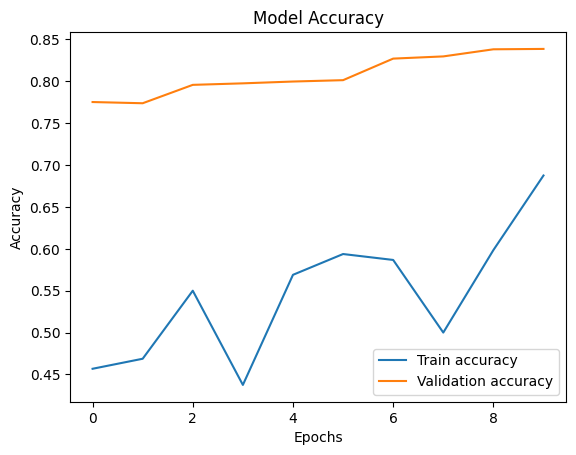

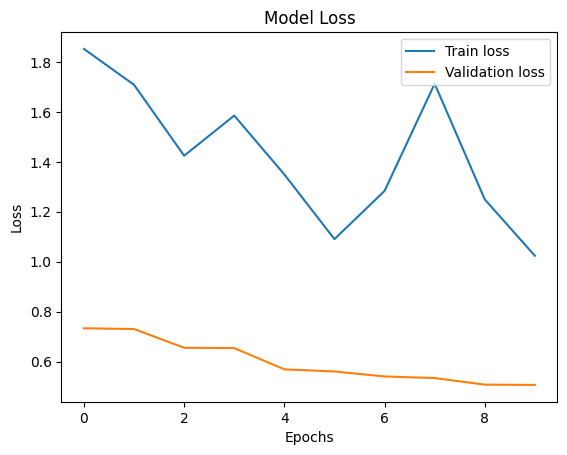

In [10]:
# Visualisierung der Trainingshistorie
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_class_for_image(img_path, model, train_generator):
  img = load_img(img_path, target_size=(224, 224))  # Bildgröße auf 224x224 ändern
  img_array = img_to_array(img)  # Bild in Array umwandeln
  img_array = np.expand_dims(img_array, axis=0)  # Dimension für das Batch hinzufügen
  img_array = img_array / 255.0  # Skalierung

  # Vorhersage machen
  prediction = model.predict(img_array)
  predicted_class = np.argmax(prediction, axis=1)  # Index der vorhergesagten Klasse

  # Label
  predicted_class_name = list(train_generator.class_indices.keys())[predicted_class[0]]
  return predicted_class_name

In [24]:
# Liste von Bildpfaden
image_paths = [
    "/content/test_dataset/Apple___healthy/image (1001).JPG",
    "/content/test_dataset/Apple___Apple_scab/image (1).JPG",
    "/content/test_dataset/Cherry___Powdery_mildew/image (1002).JPG",
    "/content/test_dataset/Corn___Common_rust/image (1005).JPG",
    "/content/test_dataset/Corn___healthy/image (100).jpg",
    "/content/test_dataset/Potato___Late_blight/image (1).JPG"
]

# Ausgabe der Vorhersagen
for img_path in image_paths:
    predicted_class_name = predict_class_for_image(img_path, model, test_generator)
    print(f"Bild: {img_path} -> Vorhergesagte Klasse: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Bild: /content/test_dataset/Apple___healthy/image (1001).JPG -> Vorhergesagte Klasse: Apple___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Bild: /content/test_dataset/Apple___Apple_scab/image (1).JPG -> Vorhergesagte Klasse: Apple___Apple_scab
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Bild: /content/test_dataset/Cherry___Powdery_mildew/image (1002).JPG -> Vorhergesagte Klasse: Cherry___Powdery_mildew
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Bild: /content/test_dataset/Corn___Common_rust/image (1005).JPG -> Vorhergesagte Klasse: Corn___Common_rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Bild: /content/test_dataset/Corn___healthy/image (100).jpg -> Vorhergesagte Klasse: Corn___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Bild: /content/test_dataset/Potato___Late_blight/image (1).JPG -> Vorhergesagte Klasse: Tomato___Spider_mites Two-spotted_spider_mite
